# Lecture 13 - Twitter Data Collection
In this notebook we will learn how to collect Twitter data using the Twitter API. 

<ol type = 1>
<li> Recent Keyword Tweets</li>
    <ol type = a>
        <li> Collect recent tweets containing keywords</li>
    </ol>
<li> Historic Keyword Tweets (Requires Academic API Access)</li>
    <ol type = a>
        <li> Collect historic tweets containing keywords</li>
    </ol>
<li> Screen Names From User IDs</li>
    <ol type = a>
        <li> Collect screen names from user IDs</li>
        <li> Update keyword tweets database with screen names </li>
    </ol>
<li> User Profiles</li>
    <ol type = a>
        <li> Collect user profiles</li>
    </ol>
 
<li>User Tweets</li>
    <ol type = a>
        <li>Collect the tweets posted by specific users</li>
    </ol>

<li>User Followings</li>
    <ol type = a>
        <li>Collect the followings for a set of users</li>
    </ol>

<li>Build Networks</li>
    <ol type = a>
        <li> Follower Network </li>
            <ol type = a>
                <li>Build follower network from a database of user followings</li>
            </ol>
        <li> Interaction Network </li>
            <ol type = a>
                <li>Build ineration network from a database of keyword tweets</li>
            </ol>
        <li> Similarity Network </li>
            <ol type = a>
                <li>Build similarity network  from an interaction network (for community detection)</li>
            </ol>
    </ol>
    
    
This notebook will not work in Colab.  Please run it on your local machine.

# Clones, installs, and imports


## Clone GitHub Repository

You will have to clone the repository to your local machine before running this notebook.  This can be done from a terminal by typing `git clone https://github.com/zlisto/social_media_analytics.git`.

If you have already cloned this repository before, but want to update to the current version, from a terminal change directory to `social_media_analytics` and then type `git pull`.

## Install Requirements 

In [2]:
!pip install -r requirements.txt


     ---------------------------------------- 58.3/58.3 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 20.6 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 12.6 MB/s eta 0:00:00
     -------------------------------------- 153.1/153.1 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 88.2/88.2 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.6/1.6 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 55.6/55.6 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: sta

## Bearer Token

After cloning or pulling the repository, they file `scripts/config.py` will be overwritten to a blank file.  You will need to edit the file by pasting in your Twitter API bearer token as follows: `BEARER0 = 'your bearer token here as a string'`.  This gives you access to the Twitter API.  You can access your bearer token here: https://developer.twitter.com/en/portal/dashboard


## Import Packages

The important import is from `scripts.api` where your bearer token is imported as the variable `BEARER0`.

In [1]:
%load_ext autoreload
%autoreload 2

from scripts.api import *

from scripts.create_graph import *
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

pd.set_option("display.max_colwidth", None)


# Collect Recent Tweets by Keyword with the Twitter API

The code below allows you to collect recent tweets (up to seven days ago) that contain a keyword, or one of many in a set of keywords.  The tweets will be saved to a database with filename `fname_db` in a table called `"keyword_tweets"`.  

The user inputs are as follows:

1. `fname_db` =  the database filename where you want to store the tweets.  Do not add the `".db"` suffix.

2. `target_total` = the total number of tweets you want to collect per keyword.

3. `keywords`  = a list of the words you want to search for.  Even if you have one keyword, it must still be in a list.

6. `retweets` = `True` if you want to collect retweets, otherwise `False` if you only want to get original tweets.

In [2]:
fname_db = f"data/lecture_13"  
target_total = 100
keywords = ['UFC285'] 
retweets = False

## Collect Tweets

The `for` loop will go through each keyword in `keywords` and collect up to `target_total` tweets per keyword.  The tweets will be saved to the database in `fname_db` in the table `keyword_tweets`.



In [3]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.

#DB.delete(table_name='keyword_tweets', path=fname_db)  


[2023-03-05 20:23:57.763] [INFO] [api:delete:26] Deleting table keyword_tweets


In [4]:
#recent search
for keyword in keywords:
    print(f"Getting recent tweets for {keyword}")
    df_keyword = History.fetch_recent(keyword=keyword,  
                    target_total=target_total, retweets=retweets)       
    DB.write(table_name='keyword_tweets', path=fname_db, data=df_keyword)


Getting recent tweets for UFC285
[2023-03-05 20:24:05.509] [INFO] [api:fetch_recent:302] Fetched 100 tweets
[2023-03-05 20:24:05.570] [INFO] [api:write:61] Writing 100 rows to table keyword_tweets


## Check `"keyword_tweets"` Table

We will add some columns to the keyword tweets dataframe to make a nice time series plot.

In [6]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

format = "%Y-%m-%d %H:%M:%S"
df_keyword ['created_at_datetime'] = pd.to_datetime(df_keyword ['created_at'],format=format).dt.tz_localize(None)
df_keyword .sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
df_keyword ['tweet_indicator'] = np.ones(len(df_keyword ))
df_keyword ['rate_1D'] = df_keyword .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
df_keyword ['rate_7D'] = df_keyword .rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7




100 keyword tweets


C:\Users\trz2\AppData\Local\Temp\ipykernel_22800\890716987.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['created_at', 'entities', 'geo', 'lang', 'screen_name', 'text'], dtype='object')
  df_keyword ['rate_1D'] = df_keyword .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
C:\Users\trz2\AppData\Local\Temp\ipykernel_22800\890716987.py:9: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['created_at', 'entities', 'geo', 'lang', 'screen_name', 'text'], dtype='object')
  df_keyword ['rate_7D'] = df_keyword .rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7


In [7]:
df_keyword.sort_values(by = 'retweet_count', ascending = False)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,impression_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,tweet_indicator,rate_1D,rate_7D
39,2023-03-06T00:52:27.000Z,None,Family of Champions 🏆🏆🏆 #UFC285 https://t.co/UJLDwrKHG4,en,84,11,892,9,37067,1632544637356318721,1062738433716686848,1632544637356318721,nan,nan,"{'urls': [{'start': 32, 'end': 55, 'url': 'https://t.co/UJLDwrKHG4', 'expanded_url': 'https://twitter.com/espnmma/status/1632544637356318721/photo/1', 'display_url': 'pic.twitter.com/UJLDwrKHG4', 'media_key': '3_1632544632176361472'}], 'annotations': [{'start': 25, 'end': 30, 'probability': 0.5923, 'type': 'Other', 'normalized_text': 'UFC285'}], 'hashtags': [{'start': 24, 'end': 31, 'tag': 'UFC285'}]}",2023-03-06 00:52:27,1.0,61.0,8.714286
11,2023-03-06T01:13:39.000Z,None,Good job Jon Jones… #UFC285 https://t.co/YgRIPms4io,en,15,6,136,0,7558,1632549971319988225,28951400,1632549971319988225,nan,nan,"{'urls': [{'start': 28, 'end': 51, 'url': 'https://t.co/YgRIPms4io', 'expanded_url': 'https://twitter.com/ChaelSonnen/status/1632549971319988225/video/1', 'display_url': 'pic.twitter.com/YgRIPms4io', 'media_key': '13_1632549718336360448'}], 'annotations': [{'start': 9, 'end': 17, 'probability': 0.9696, 'type': 'Person', 'normalized_text': 'Jon Jones'}, {'start': 21, 'end': 26, 'probability': 0.4639, 'type': 'Other', 'normalized_text': 'UFC285'}], 'hashtags': [{'start': 20, 'end': 27, 'tag': 'UFC285'}]}",2023-03-06 01:13:39,1.0,90.0,12.857143
14,2023-03-06T01:12:36.000Z,None,"https://t.co/ZAK6aABaL0 This is what a mma Twitter clown does…argues with me the whole day about Neal, then the next day steals my take. Hilarious!!! You’re a fan 🤣🤣 #UFC285 https://t.co/xbQsJ7Cj7C",en,4,1,4,1,79,1632549706978017280,1610123232346095616,1632549706978017280,nan,nan,"{'urls': [{'start': 0, 'end': 23, 'url': 'https://t.co/ZAK6aABaL0', 'expanded_url': 'https://twitter.com/deeblackmma3/status/1631730056472010790?s=46&t=wQNZ0O8a3tRfynvWdZX7mQ', 'display_url': 'twitter.com/deeblackmma3/s…'}, {'start': 174, 'end': 197, 'url': 'https://t.co/xbQsJ7Cj7C', 'expanded_url': 'https://twitter.com/deeblackmma3/status/1632549706978017280/photo/1', 'display_url': 'pic.twitter.com/xbQsJ7Cj7C', 'media_key': '3_1632549702431301632'}], 'annotations': [{'start': 43, 'end': 49, 'probability': 0.9869, 'type': 'Other', 'normalized_text': 'Twitter'}, {'start': 97, 'end': 100, 'probability': 0.7527, 'type': 'Person', 'normalized_text': 'Neal'}, {'start': 167, 'end': 172, 'probability': 0.7812, 'type': 'Other', 'normalized_text': 'UFC285'}], 'hashtags': [{'start': 166, 'end': 173, 'tag': 'UFC285'}]}",2023-03-06 01:12:36,1.0,86.0,12.285714
25,2023-03-06T01:04:18.000Z,None,Milishaaa\nhttps://t.co/FXHNoO0ODP\n\nLink telegram\nhttps://t.co/lQmD0nbGrr \n\n21++\nhttps://t.co/DI7JmQd4B8\n\n#UFC285 #BahrainGP #LIVMUN #BLACKPINkinKualaLumpur https://t.co/kaStY8WZLP,en,4,0,4,0,8,1632547620047695872,1628331693936623617,1632547620047695872,nan,nan,"{'urls': [{'start': 10, 'end': 33, 'url': 'https://t.co/FXHNoO0ODP', 'expanded_url': 'https://dood.yt/f/d4njbxc1hh', 'display_url': 'dood.yt/f/d4njbxc1hh', 'status': 403, 'unwound_url': 'https://dood.yt/f/d4njbxc1hh'}, {'start': 49, 'end': 72, 'url': 'https://t.co/lQmD0nbGrr', 'expanded_url': 'https://t.me/doodstreamteleLink', 'display_url': 't.me/doodstreamtele…', 'images': [{'url': 'https://pbs.twimg.com/news_img/1631642205604511744/8Zau0ma2?format=png&name=orig', 'width': 128, 'height': 128}, {'url': 'https://pbs.twimg.com/news_img/1631642205604511744/8Zau0ma2?format=png&name=150x150', 'width': 128, 'height': 128}], 'status': 200, 'title': 'Telegram: Contact @doodstreamteleLink', 'unwound_url': 'https://t.me/doodstreamteleLink'}, {'start': 80, 'end': 103, 'url': 'https://t.co/DI7JmQd4B8', 'expanded_url': 'http://xnxx-freeporn.blogspot.com', 'display_url': 'xnxx-freeporn.blogspot.com', 'images': [{'url': 'https://pbs.twimg.com/news_img/1631582639772831744/

In [8]:

print(f"Head:\n{df_keyword .created_at.head(n=3)}")
print(f"Tail:\n{df_keyword .created_at.tail(n=3)}")


Head:
99    2023-03-06T00:10:39.000Z
98    2023-03-06T00:11:07.000Z
97    2023-03-06T00:11:33.000Z
Name: created_at, dtype: object
Tail:
2    2023-03-06T01:22:39.000Z
1    2023-03-06T01:23:27.000Z
0    2023-03-06T01:23:38.000Z
Name: created_at, dtype: object


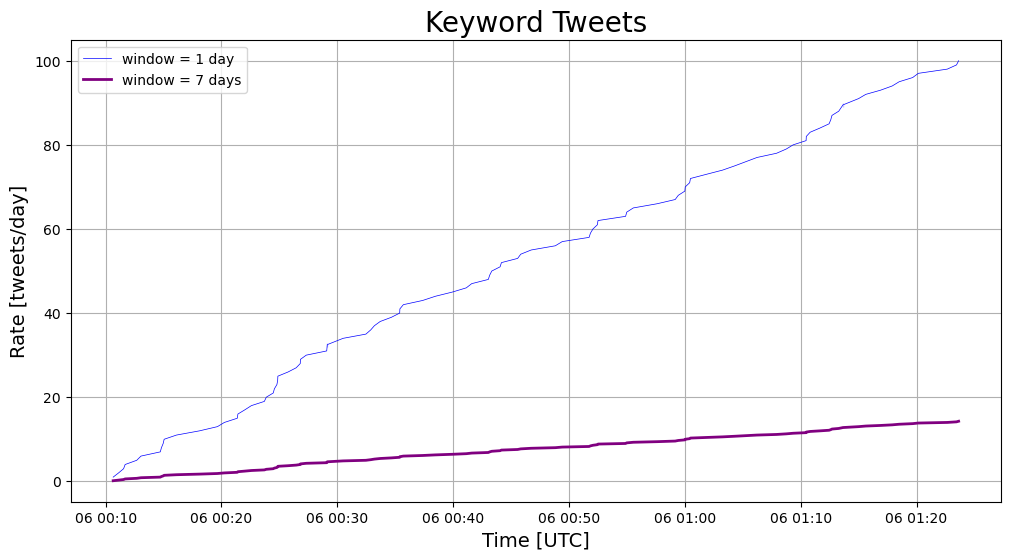

In [11]:

fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_keyword , 
             x = 'created_at_datetime',
             y = 'rate_1D',
             label = 'window = 1 day',
             linewidth = .5,
             color = 'blue')
sns.lineplot(data = df_keyword , 
             x = 'created_at_datetime',
             y = 'rate_7D',
             label = 'window = 7 days', 
             linewidth = 2,
             color = 'purple')

plt.grid()
plt.xlabel("Time [UTC]", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

# Collect Historic Tweets by Keyword with the Twitter API (Requires Academic Access)

The code below allows you to collect historic tweets that contain a keyword, or one of many in a set of keywords.  You need academic access for this to work.  If you only have essential access, you can only do a search for recent tweets.  The tweets will be saved to a database with filename `fname_db` in a table called `"keyword_tweets"`.  

The user inputs are as follows:

1. `fname_db` =  the database filename where you want to store the tweets.  Do not add the `".db"` suffix.

2. `target_total` = the total number of tweets you want to collect per keyword.

3. `keywords`  = a list of the words you want to search for.  Even if you have one keyword, it must still be in a list.

4. `start_date` = string of the earliest date of tweets you want.  Should be in `yyyy-mm-dd` format.

5. `end_date` = string of the latest date of tweets you want.  Should be in `yyyy-mm-dd` format.  WARNING:  If `end_date` is a future date, the code will not work.  Make sure not to go beyond today.

6. `retweets` = `True` if you want to collect retweets, otherwise `False` if you only want to get original tweets.

In [4]:
fname_db = f"data/lecture_13"  
target_total = 200  
keywords = ['vaccine'] 
start_date = '2023-03-05'   
end_date = '2023-03-06'
retweets = False

## Collect Historic Tweets

In [5]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.

#DB.delete(table_name='keyword_tweets', path=fname_db)  


[2023-03-05 20:32:20.862] [INFO] [api:delete:26] Deleting table keyword_tweets


In [6]:
for keyword in keywords:
    print(f"Getting tweets for {keyword}")
    df_keyword = History.fetch(keyword=keyword, start_date= start_date, end_date= end_date, 
                    target_total=target_total, retweets=retweets)       
    DB.write(table_name='keyword_tweets', path=fname_db, data=df_keyword)

df_keyword.head(n=3)    

Getting tweets for vaccine
[2023-03-05 20:32:23.395] [INFO] [api:fetch:236] Fetched 100 tweets
[2023-03-05 20:32:24.948] [INFO] [api:fetch:236] Fetched 99 tweets
[2023-03-05 20:32:26.518] [INFO] [api:fetch:236] Fetched 100 tweets
[2023-03-05 20:32:28.085] [INFO] [api:fetch:236] Fetched 100 tweets
[2023-03-05 20:32:28.174] [INFO] [api:write:61] Writing 399 rows to table keyword_tweets


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,impression_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
0,2023-03-05T23:59:59.000Z,None,@HilkerCharles27 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H,en,0,0,0,0,2,1632531433246924800,241935465,1632478359270617088,1586529031725400064,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'HilkerCharles27', 'id': '1586529031725400064'}], 'urls': [{'start': 52, 'end': 75, 'url': 'https://t.co/DJ6O20sE5H', 'expanded_url': 'http://bit.ly/3mjHKp3', 'display_url': 'bit.ly/3mjHKp3', 'images': [{'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=orig', 'width': 320, 'height': 320}, {'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=150x150', 'width': 150, 'height': 150}], 'status': 200, 'title': 'VACCINE FREEDOM FIGHTERS', 'description': 'Unvaccinated Freedom fighters community ; This group is for the vaxxed and unvaxed that are fighting and standing for FREEDOM WORLDWIDE 🌍', 'unwound_url': 'https://t.me/+g_EaqDYbHI5kMmZk'}]}"
1,2023-03-05T23:59:57.000Z,None,@Holtmoney51 @ChampionsMovie Yet here I am. Alive and well. And without a mystery juice flowing in my body. Ever wonder why Pfizer wasn’t allowed to distribute the “vaccine” in India?,en,0,1,1,0,8,1632531424262668291,3329305187,1631431521151373314,1105210543,nan,"{'mentions': [{'start': 0, 'end': 12, 'username': 'Holtmoney51', 'id': '1105210543'}, {'start': 13, 'end': 28, 'username': 'ChampionsMovie', 'id': '1488285930448465927'}], 'annotations': [{'start': 124, 'end': 129, 'probability': 0.9931, 'type': 'Organization', 'normalized_text': 'Pfizer'}, {'start': 177, 'end': 181, 'probability': 0.9753, 'type': 'Place', 'normalized_text': 'India'}]}"
2,2023-03-05T23:59:55.000Z,None,@AlessioBruni007 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H,en,0,0,0,0,2,1632531417002377216,241935465,1632478359270617088,1456716779980562438,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'AlessioBruni007', 'id': '1456716779980562438'}], 'urls': [{'start': 52, 'end': 75, 'url': 'https://t.co/DJ6O20sE5H', 'expanded_url': 'http://bit.ly/3mjHKp3', 'display_url': 'bit.ly/3mjHKp3', 'images': [{'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=orig', 'width': 320, 'height': 320}, {'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=150x150', 'width': 150, 'height': 150}], 'status': 200, 'title': 'VACCINE FREEDOM FIGHTERS', 'description': 'Unvaccinated Freedom fighters community ; This group is for the vaxxed and unvaxed that are fighting and standing for FREEDOM WORLDWIDE 🌍', 'unwound_url': 'https://t.me/+g_EaqDYbHI5kMmZk'}]}"
3,2023-03-05T23:59:52.000Z,None,@TheRealWadeWil1 I was not supportive of his Warp Speed for this vaccine and certainly not supportive of his allowing Fraudchi to have so much say. He definitely lost points with me on those two but he is still the better man for the job over all.,en,0,0,1,0,3,1632531406029979648,1586156846200619012,1632206296119140354,1428106430272483329,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'TheRealWadeWil1', 'id': '1428106430272483329'}], 'annotations': [{'start': 45, 'end': 54, 'probability': 0.6446, 'type': 'Other', 'normalized_text': 'Warp Speed'}, {'start': 118, 'end': 125, 'probability': 0.6584, 'type': 'Person', 'normalized_text': 'Fraudchi'}]}"
4,2023-03-05T23:59:52.000Z,None,"@pedwards_phil @Otto_English Agreed, they hold information back until it has a purpose e.g. a dip in vaccine uptake. If all info was released at once nobody would continue to get the necessary vaccines / boosters.\n\nIt's manipulation but necessary but the gen public are morons to be honest.",en,0,1,1,0,6,1632531404117475328,880867305797935104,1632410914916823040,914994564397764610,nan,"{'mentions': [{'start': 0, 'end': 14, 'username': 'pedwards_phil', 'id': '914994564397764610'}, {'start': 15, 'end':

In [8]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

df_keyword.head(n=3)

399 keyword tweets


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,impression_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
0,2023-03-05T23:59:59.000Z,None,@HilkerCharles27 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H,en,0,0,0,0,2,1632531433246924800,241935465,1632478359270617088,1586529031725400064,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'HilkerCharles27', 'id': '1586529031725400064'}], 'urls': [{'start': 52, 'end': 75, 'url': 'https://t.co/DJ6O20sE5H', 'expanded_url': 'http://bit.ly/3mjHKp3', 'display_url': 'bit.ly/3mjHKp3', 'images': [{'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=orig', 'width': 320, 'height': 320}, {'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=150x150', 'width': 150, 'height': 150}], 'status': 200, 'title': 'VACCINE FREEDOM FIGHTERS', 'description': 'Unvaccinated Freedom fighters community ; This group is for the vaxxed and unvaxed that are fighting and standing for FREEDOM WORLDWIDE 🌍', 'unwound_url': 'https://t.me/+g_EaqDYbHI5kMmZk'}]}"
1,2023-03-05T23:59:57.000Z,None,@Holtmoney51 @ChampionsMovie Yet here I am. Alive and well. And without a mystery juice flowing in my body. Ever wonder why Pfizer wasn’t allowed to distribute the “vaccine” in India?,en,0,1,1,0,8,1632531424262668291,3329305187,1631431521151373314,1105210543,nan,"{'mentions': [{'start': 0, 'end': 12, 'username': 'Holtmoney51', 'id': '1105210543'}, {'start': 13, 'end': 28, 'username': 'ChampionsMovie', 'id': '1488285930448465927'}], 'annotations': [{'start': 124, 'end': 129, 'probability': 0.9931, 'type': 'Organization', 'normalized_text': 'Pfizer'}, {'start': 177, 'end': 181, 'probability': 0.9753, 'type': 'Place', 'normalized_text': 'India'}]}"
2,2023-03-05T23:59:55.000Z,None,@AlessioBruni007 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H,en,0,0,0,0,2,1632531417002377216,241935465,1632478359270617088,1456716779980562438,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'AlessioBruni007', 'id': '1456716779980562438'}], 'urls': [{'start': 52, 'end': 75, 'url': 'https://t.co/DJ6O20sE5H', 'expanded_url': 'http://bit.ly/3mjHKp3', 'display_url': 'bit.ly/3mjHKp3', 'images': [{'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=orig', 'width': 320, 'height': 320}, {'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=150x150', 'width': 150, 'height': 150}], 'status': 200, 'title': 'VACCINE FREEDOM FIGHTERS', 'description': 'Unvaccinated Freedom fighters community ; This group is for the vaxxed and unvaxed that are fighting and standing for FREEDOM WORLDWIDE 🌍', 'unwound_url': 'https://t.me/+g_EaqDYbHI5kMmZk'}]}"


# Collect Screen Names of Keyword Tweets

The Twitter API only gives the ID of a tweet author.  To get the screen name we have to run the code below.  This code collects the screen names for a list of author IDs, then saves the screen names along with the tweets in a new database. This is a slow query, so it is advisable to instead get a smaller set of author IDs you are interested in, and then collect their screen names.

The user inputs are as follows:

`authorids` = list of author IDs as strings.  You can obtain the entire list from the `keyword_tweets` table, or you can input your own list manually.

`fname_db` = name of database where you want to save the keyword tweets plus the screen names

In [9]:
fname_db = f"data/lecture_13"  #database filenmae

#load database of keyword_tweets into dataframe
df_keyword  = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")


399 keyword tweets


In [10]:
#get author IDs for keyword tweets table
authorids = df_keyword.author_id.unique().tolist()
print(f"userids has {len(authorids)} author ids")

userids has 294 author ids


In [12]:
#or create your own list of author IDs
authorids = ['898536559057793024',
 '1441860325968465924',
 '277219310']

print(f"userids has {len(authorids)} author ids")

userids has 3 author ids


In [11]:
#for loop that looks up the screen name (called username here) for each user ID
usernames = {}
c=0
print(f"We are going to collect screen names for {len(authorids)} users")
for authorid in authorids:
    username = User.id_to_username(user_id = authorid, token=0) #collect user profiles using Twitter API in a dataframe
    usernames[authorid] = username
    c+=1
    if c%100 ==0:print(f"user {c}/{len(authorids)}")
print(f"Collected screen names for {c} users")

We are going to collect screen names for 294 users
user 100/294
user 200/294
Collected screen names for 294 users


In [12]:
#look at the screen names
usernames

{'241935465': 'mayelly_09',
 '3329305187': 'hogimus96',
 '1586156846200619012': 'UltraMagaGemma',
 '880867305797935104': 'BaftyC',
 '1511864806608973825': 'Christo21854255',
 '1227987223418671104': 'stormlecat',
 '3245489649': 'juliefig45',
 '1426283746337206275': 'BillyBaroo412',
 '2303867828': 'GreggLRivera',
 '1560502044': 'FrankRizzoNY',
 '1285568463616999426': 'FrightSandra',
 '1484469216178810883': 'ChrisEd16512812',
 '1481420306791215105': 'AlvarezInt',
 '896067536713912320': 'SusanHe32229602',
 '1033169786874814465': 'DSlayer520',
 '1150776185300930561': 'elprezedente1',
 '1591505173746262035': 'TonyLewis1953',
 '1582509182904836100': 'DebXan',
 '1589476178301108225': 'be3_flower',
 '954483158883299328': 'THEKATlNATOR',
 '1516699454568603649': '0_neo3',
 '1584497057599037442': 'IwillFactCheck_',
 '1489810863548731392': 'nononneinnyet',
 '1632530999505739777': 'juan_follansbee',
 '1520551016109903872': 'kalypso1066',
 '1329582751389941760': 'Fixitguy8',
 '207160117': 'mh379',
 '

In [13]:
#add screen_name column to dataframe/database

col = []
for author_id in df_keyword.author_id:
    if author_id in usernames:
        col.append(usernames[author_id])
    else:
        col.append(np.NaN)
        
df_keyword['screen_name'] = col


In [14]:
df_keyword[['screen_name','text']].head()

,screen_name,text
0,mayelly_09,@HilkerCharles27 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H
1,hogimus96,@Holtmoney51 @ChampionsMovie Yet here I am. Alive and well. And without a mystery juice flowing in my body. Ever wonder why Pfizer wasn’t allowed to distribute the “vaccine” in India?
2,mayelly_09,@AlessioBruni007 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H
3,UltraMagaGemma,@TheRealWadeWil1 I was not supportive of his Warp Speed for this vaccine and certainly not supportive of his allowing Fraudchi to have so much say. He definitely lost points with me on those two but he is still the better man for the job over all.
4,BaftyC,"@pedwards_phil @Otto_English Agreed, they hold information back until it has a purpose e.g. a dip in vaccine uptake. If all info was released at once nobody would continue to get the necessary vaccines / boosters.\n\nIt's manipulation but necessary but the gen public are morons to be honest."


### Update `"keyword_tweets"` Table

In [15]:
#delete old table
DB.delete(table_name='keyword_tweets', path=fname_db)  

#save dataframe with screen names to table
DB.write(table_name='keyword_tweets', path=fname_db, data=df_keyword)  #Save profiles to database


[2023-03-05 20:34:44.522] [INFO] [api:delete:26] Deleting table keyword_tweets
[2023-03-05 20:34:44.548] [INFO] [api:write:61] Writing 399 rows to table keyword_tweets


### Check `"keyword_tweets"` Table 

We will load the keyword tweet table into a dataframe and look at the rows that have screen names.

In [16]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

print(f"Tweets with screen names")
df_keyword.loc[df_keyword.screen_name.isna()==False,['screen_name','text']].head()

399 keyword tweets
Tweets with screen names


,screen_name,text
0,mayelly_09,@HilkerCharles27 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H
1,hogimus96,@Holtmoney51 @ChampionsMovie Yet here I am. Alive and well. And without a mystery juice flowing in my body. Ever wonder why Pfizer wasn’t allowed to distribute the “vaccine” in India?
2,mayelly_09,@AlessioBruni007 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H
3,UltraMagaGemma,@TheRealWadeWil1 I was not supportive of his Warp Speed for this vaccine and certainly not supportive of his allowing Fraudchi to have so much say. He definitely lost points with me on those two but he is still the better man for the job over all.
4,BaftyC,"@pedwards_phil @Otto_English Agreed, they hold information back until it has a purpose e.g. a dip in vaccine uptake. If all info was released at once nobody would continue to get the necessary vaccines / boosters.\n\nIt's manipulation but necessary but the gen public are morons to be honest."


In [17]:
df_keyword.sample(n=10)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,impression_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
345,2023-03-05T23:43:49.000Z,dystopian_DU,@goodfoodgal I don’t know but did you see the Russian inventor of the Sputnik Covid vaccine was strangled to death in his apartment just recently? Weird. \n\nhttps://t.co/GmGAada5h3,en,7,4,23,0,547,1632527366831624193,1501389242567561216,1632517745190518785,3000964616,nan,"{'urls': [{'start': 156, 'end': 179, 'url': 'https://t.co/GmGAada5h3', 'expanded_url': 'https://www.couriermail.com.au/news/creator-of-russias-sputnik-covid-vaccine-strangled-to-death-in-latest-mystery-murder/news-story/66c1d9549024e7c87959f946524c96ad', 'display_url': 'couriermail.com.au/news/creator-o…', 'images': [{'url': 'https://pbs.twimg.com/news_img/1632527367330725889/K9UjfS8j?format=jpg&name=orig', 'width': 1280, 'height': 719}, {'url': 'https://pbs.twimg.com/news_img/1632527367330725889/K9UjfS8j?format=jpg&name=150x150', 'width': 150, 'height': 150}], 'status': 200, 'title': 'Covid vax maker ‘strangled with belt’', 'description': 'One of the creators of Russia’s Covid vaccine has been found brutally strangled to death in his Moscow apartment, in the latest mystery murder surrounding the country’s elite.', 'unwound_url': 'https://www.couriermail.com.au/news/creator-of-russias-sputnik-covid-vaccine-strangled-to-death-in-latest-mystery-murder/news-story/66c1d9549024e7c87959f946524c96ad'}], 'annotations': [{'start': 70, 'end': 76, 'probability': 0.8648, 'type': 'Other', 'normalized_text': 'Sputnik'}, {'start': 78, 'end': 90, 'probability': 0.7566, 'type': 'Other', 'normalized_text': 'Covid vaccine'}], 'mentions': [{'start': 0, 'end': 12, 'username': 'goodfoodgal', 'id': '3000964616'}]}"
252,2023-03-05T23:49:24.000Z,1956_rebecca,@LauraLoomer Thank God I learned the truth about the Covid vaccine before it was available to me!!,en,0,0,0,0,6,1632528771814404096,1275238553266487296,1632501299999588357,537709549,nan,"{'mentions': [{'start': 0, 'end': 12, 'username': 'LauraLoomer', 'id': '537709549'}]}"
73,2023-03-05T23:57:43.000Z,mayelly_09,@Catheri43520143 We All Stand against the vaccine \n\nhttps://t.co/DJ6O20sE5H,en,0,0,0,0,3,1632530863006130177,241935465,1632478359270617088,1595605569926201344,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'Catheri43520143', 'id': '1595605569926201344'}], 'urls': [{'start': 52, 'end': 75, 'url': 'https://t.co/DJ6O20sE5H', 'expanded_url': 'http://bit.ly/3mjHKp3', 'display_url': 'bit.ly/3mjHKp3', 'images': [{'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=orig', 'width': 320, 'height': 320}, {'url': 'https://pbs.twimg.com/news_img/1632178010643128321/jnVsC0wL?format=jpg&name=150x150', 'width': 150, 'height': 150}], 'status': 200, 'title': 'VACCINE FREEDOM FIGHTERS', 'description': 'Unvaccinated Freedom fighters community ; This group is for the vaxxed and unvaxed that are fighting and standing for FREEDOM WORLDWIDE 🌍', 'unwound_url': 'https://t.me/+g_EaqDYbHI5kMmZk'}]}"
88,2023-03-05T23:57:05.000Z,john_longlade,"@BotHatesTheTurd @elonmusk Now do serious vaccine injuries/deaths, data manipulation. That drama teacher is much more evil &amp; cold hearted. Divided and killed.",en,0,1,0,0,11,1632530705358938118,806109731815301121,1632240309546500097,1174798848100880391,nan,"{'mentions': [{'start': 0, 'end': 16, 'username': 'BotHatesTheTurd', 'id': '1174798848100880391'}, {'start': 17, 'end': 26, 'username': 'elonmusk', 'id': '44196397'}]}"
134,2023-03-05T23:55:18.000Z,UndercoverNurd,@Photero @ksorbs Do YOU realize that the vaccine doesn't actually protect you from contractingthe disease? Truth beats science.,en,0,0,0,0,3,1632530253762494464,1578613090903629825,1632452757834674177,19997829,nan,"{'mentions': [{'start': 0, 'end': 8, 'username': 'Photero', 'id': '19997829'}, {'start': 9, 'end': 16, 'username': 'ksorbs', 'id': '33608041'}], 'annotations': [{'start': 98, 'end': 104, 'proba

# Collect User Profiles

The code below allows you to collect Twitter profiles from specific users.  The tweets will be saved to a database with filename `fname_db` in a table called `"users"`.  

The user inputs are as follows:

1. `fname_db` = the database filename where you want to store the profiles.  Do not add the `".db"` suffix.

3. `screen_names`  = a list of the screen name you want profiles for.  Even if you have one screen name, it must still be in a list.





In [18]:
fname_db = "data/lecture_13"
screen_names =['Cristiano', 'BLACKPINK', 'KingJames']


In [19]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.

DB.delete(table_name='users', path=fname_db)

[2023-03-05 20:35:22.702] [INFO] [api:delete:26] Deleting table users


In [20]:
#collect user profiles
df_profiles = User.user_info(screen_names)  #collect user profiles using Twitter API in a dataframe

#write profiles to users table
DB.write(table_name='users', path=fname_db, data=df_profiles)  #Save profiles to database

#look at head of table
df_profiles.head()

[2023-03-05 20:35:27.060] [INFO] [api:write:61] Writing 3 rows to table users


,created_at,name,username,description,id,location,followers_count,following_count,listed_count,tweet_count
0,2010-06-14T19:09:20.000Z,Cristiano Ronaldo,Cristiano,This Privacy Policy addresses the collection and use of personal information - https://t.co/N9W2J34YdA,155659213,NaN,107925993,67,85635,3886
1,2020-06-19T05:32:29.000Z,BLACKPINKOFFICIAL,BLACKPINK,BLΛƆKPIИK,1273850774380883975,NaN,8610446,0,8100,898
2,2009-03-06T16:25:53.000Z,LeBron James,KingJames,EST. AKRON - ST.V/M Class of '03 https://t.co/TrZZrgR90t #IPROMISE,23083404,Amongst La Familia!,52855515,186,46337,8878


## Check `"users"` Table

In [21]:
df_profiles = DB.fetch(table_name='users', path=fname_db)  
df_profiles.head()

,created_at,name,username,description,id,location,followers_count,following_count,listed_count,tweet_count
0,2010-06-14T19:09:20.000Z,Cristiano Ronaldo,Cristiano,This Privacy Policy addresses the collection and use of personal information - https://t.co/N9W2J34YdA,155659213,None,107925993,67,85635,3886
1,2020-06-19T05:32:29.000Z,BLACKPINKOFFICIAL,BLACKPINK,BLΛƆKPIИK,1273850774380883975,None,8610446,0,8100,898
2,2009-03-06T16:25:53.000Z,LeBron James,KingJames,EST. AKRON - ST.V/M Class of '03 https://t.co/TrZZrgR90t #IPROMISE,23083404,Amongst La Familia!,52855515,186,46337,8878


# Collect User Tweets

The code below allows you to collect tweets of specific users.  The tweets will be saved to a database with filename `fname_db` in a table called `"user_tweets"`.  

The user inputs are as follows:

1. `fname_db` = the database filename where you want to store the tweets.  Do not add the `".db"` suffix.

2. `max_results` = the total number of tweets you want to collect per user.

3. `screen_names`  = a list of screen names you want to search for.  Even if you have one screen name, it must still be in a list.

4. `start_date` = string of the earliest date of tweets you want.  Should be in `yyyy-mm-dd` format. (This doesn't seem to work for user tweets).

5. `end_date` = string of the latest date of tweets you want.  Should be in `yyyy-mm-dd` format.  (This doesn't seem to work for user tweets).



In [22]:
fname_db = "data/lecture_13"
screen_names =['Cristiano', 'BLACKPINK', 'KingJames']
max_results = 100
start_date ='2016-02-01'
end_date = '2025-03-29'


In [23]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.


DB.delete(table_name='user_tweets', path=fname_db)


[2023-03-05 20:35:57.459] [INFO] [api:delete:26] Deleting table user_tweets


In [24]:
for screen_name in screen_names: 
    print(f"Collecting tweets for {screen_name}")
    user_id =  User.user_info([screen_name]).id.values[0]
    df_ut = Tweet.fetch_user_tweets(user_id, start_date, end_date,max_results)
    
    #add in a screen_name column for convenience
    df_ut['screen_name']= screen_name
    
    #write dataframe to table
    DB.write(table_name='user_tweets', path=fname_db, data=df_ut)

[2023-03-05 20:36:05.624] [INFO] [api:fetch_user_tweets:367] Fetched 100 tweets
[2023-03-05 20:36:05.688] [INFO] [api:write:61] Writing 100 rows to table user_tweets
[2023-03-05 20:36:06.274] [INFO] [api:fetch_user_tweets:367] Fetched 100 tweets
[2023-03-05 20:36:06.344] [INFO] [api:write:61] Writing 100 rows to table user_tweets
[2023-03-05 20:36:07.098] [INFO] [api:fetch_user_tweets:367] Fetched 100 tweets
[2023-03-05 20:36:07.158] [INFO] [api:write:61] Writing 100 rows to table user_tweets


## Check `"user_tweets"` Table 

In [27]:
df_ut = DB.fetch(table_name='user_tweets', path=fname_db)
df_ut.sample(n=5)


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,impression_count,id,author_id,conversation_id,in_reply_to_user_id,geo
166,2022-12-02T07:52:16.000Z,BLACKPINK,RT @Deezer: What was your favorite K-Pop release of the year? (Hint: you can look through this playlist for inspo ▶️ https://t.co/hraHuPqEG…,en,2837,0,0,0,0,1598585828069978118,1273850774380883975,1598585828069978118,nan,None
83,2022-08-31T08:12:57.000Z,Cristiano,Get goal notifications before I even finish my Siiimmm! Download the @livescore app to see what you’re missing\n\nhttps://t.co/4lzGWzFyYH https://t.co/Jr0Zfd2Gwo,en,4187,3680,68135,359,0,1564888962069676033,155659213,1564888962069676033,nan,None
196,2022-11-07T07:00:30.000Z,BLACKPINK,https://t.co/gUKTHMMHUZ,zxx,12395,390,49721,922,0,1589513105775923201,1273850774380883975,1589513094954639360,1273850774380883975,None
64,2022-10-31T15:20:47.000Z,Cristiano,RT @nikefootball: Portuguese heritage is now on their biggest icon. 🇵🇹 The legacy of CR7’s Mercs lives on. \n\n#CR7 #Merc #NikeFC https://t.c…,en,1517,0,0,0,0,1587102291227807744,155659213,1587102291227807744,nan,None
121,2023-01-19T01:08:58.000Z,BLACKPINK,#BLACKPINK 2nd VINYL LP [BORN PINK] -LIMITED EDITION-\nDetail page notice has been uploaded\n\n▶️ https://t.co/d8ia5Huo5R\n\n#블랙핑크 #BORNPINK #2ndVINYLLP #LIMITEDEDITION #20230119 #RELEASE #YG https://t.co/ZkQzIxZOa7,en,8146,403,51251,1032,1736694,1615878952442269696,1273850774380883975,1615878952442269696,nan,None


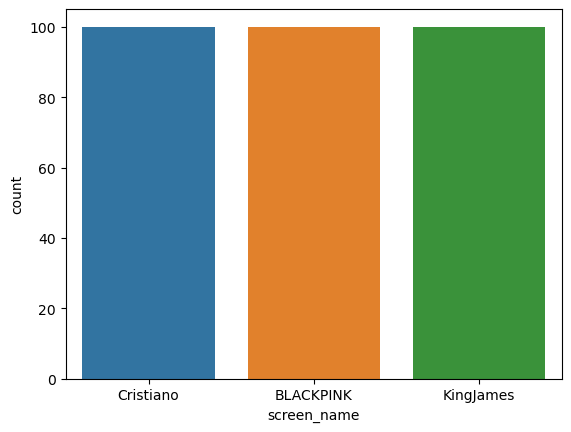

In [30]:
sns.countplot(data = df_ut, x = 'screen_name')
plt.show()

# Collect User Followings

This code will collect the followings for a group of users.  

The user inputs are as follows:

1. `fname_db` = the database filename where you want to store the followings.  Do not add the `".db"` suffix.


2. `screen_names`  = a list of screen names you want to collect followings for.  Even if you have one screen name, it must still be in a list.

3. `max_following` = the maximum number of following to get per user.  If this value is large, the code will take longer to run if you have users with a massive following count.



In [31]:
fname_db = "data/lecture_13"

screen_names =['POTUS', 'BarackObama', 'FLOTUS']
max_following = 5


In [32]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.


DB.delete(table_name='following', path = fname_db)

[2023-03-05 20:37:39.890] [INFO] [api:delete:26] Deleting table following


In [33]:
#This code queries the Twitter API for the followings.  It can be VERY slow
df_following = Follow.fetch(users=screen_names, target_total = max_following, token_number = 0, kind='following')
df_following.head()

POTUS          StephenCurry30,WHCOVIDResponse,WHCommsDir,AmbRice46,JOD46
BarackObama               chiq85,WinniePooh,Merone,girlsalliance,HGMedia
FLOTUS                  LaCasaBlanca,WhiteHouse,SecondGentleman,VP,POTUS
dtype: object

In [34]:
#write dataframe to table
DB.write(table_name='following', path=fname_db, data=df_following)

[2023-03-05 20:37:50.277] [INFO] [api:write:61] Writing 3 rows to table following


## Check `"following"` Table

In [35]:
df_following = DB.fetch(table_name='following', path=fname_db)
df_following.head()

,index,0
0,POTUS,"StephenCurry30,WHCOVIDResponse,WHCommsDir,AmbRice46,JOD46"
1,BarackObama,"chiq85,WinniePooh,Merone,girlsalliance,HGMedia"
2,FLOTUS,"LaCasaBlanca,WhiteHouse,SecondGentleman,VP,POTUS"


# Build Networks

We will created networkx objects for different networks and save them as pickle files.

## Build Follower Network From Database

This code creates the networkx object for the follower network from the database.  

The user inputs are as follows:


1. `fname_db` = database filename where you stored the followings.  Do not add the `".db"` suffix.


2. `fname_following_network` = filename to save follower network to (should end in `".pickle"`)


In [36]:
fname_db = "data/lecture_13"
fname_following_network = "data/lecture_13_following_network.pickle"

In [43]:
df_following.columns

Index(['index', '0'], dtype='object')

In [44]:
df_following = DB.fetch(table_name='following', path=fname_db)

Gf = nx.DiGraph()
V = set(df_following['index'].tolist())
for row in zip(df_following['index'], df_following['0']):
    nb = row[1].split(",")
    node = row[0]
    Gf.add_node(node)
    for u in nb:
        if u in V:
            Gf.add_edge(u,node)

nx.write_gpickle(Gf,fname_following_network)

### Draw Following Network (If Not Too Big)

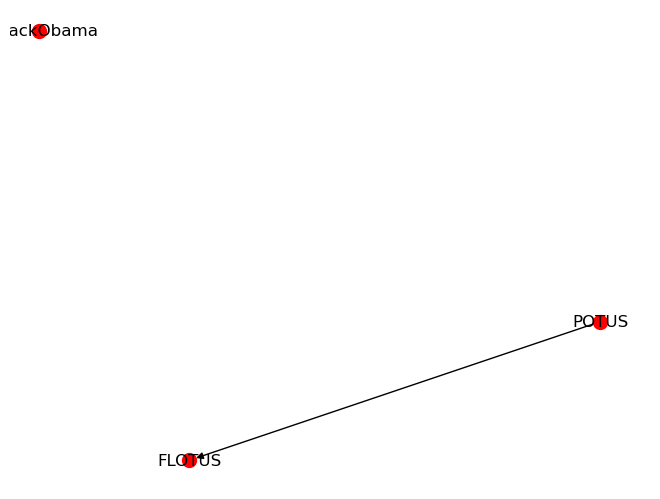

In [45]:
Gf = nx.read_gpickle(fname_following_network)

nv_max = 100  #max number of nodes to draw for
nv = Gf.number_of_nodes()
if nv<nv_max:
    pos = nx.kamada_kawai_layout(Gf.to_undirected())
    nx.draw(Gf,pos,node_size = 100, node_color = 'red', with_labels = True)
    
else: print(f"Network has {nv} nodes, which is more than {nv_max}")

## Build Interaction Network From Keyword Tweets

We can build an interaction network from the tweets in the `keyword_tweets` table using the function `interaction_network_from_tweets`.
The interaction network includes retweets, replies, and regular mentions of other users.  Our edge convention points to the person tweeting from the person being mentioned in the tweet. 

The user inputs are as follows:

1. `fname_db` = database filename where you stored the keyword tweets.  Do not add the `".db"` suffix.

2. `fname_interaction_network` = name of the file where you will save the interaction network.  Make sure it ends with `".pickle"`.

In [46]:
fname_db = 'data/lecture_13'
fname_interaction_network = 'data/lecture_13_interaction_network.pickle'


In [47]:
df_keyword= DB.fetch(table_name='keyword_tweets', path=fname_db)
G = interaction_network_from_tweets(df_keyword)
nx.write_gpickle(G, fname_interaction_network)

G has 727 nodes and 592 edges


### Draw Interaction Network (If Not Too Big)

In [48]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10
node_color = 'red'

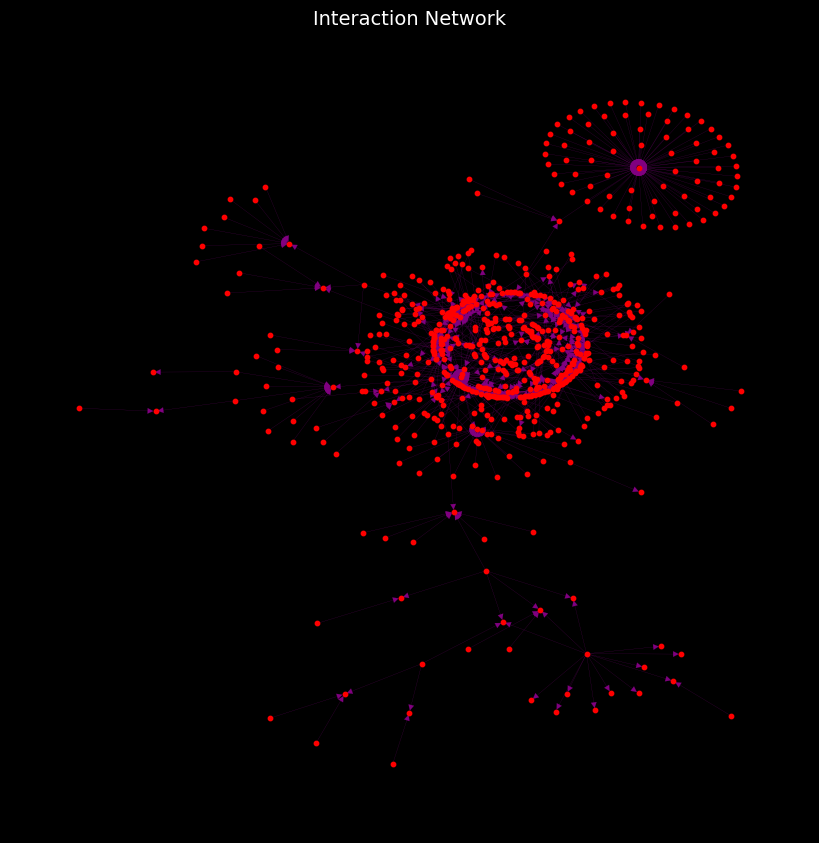

In [49]:
G = nx.read_gpickle(fname_interaction_network)

nv_max = 1000
nv = G.number_of_nodes()

if nv<nv_max:
    pos = nx.kamada_kawai_layout(G.to_undirected())  #position of each node in the network
    fig = plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_color = node_color, 
            width= edge_width, 
            edge_color=edge_color,
            node_size=node_size,
           with_labels=False,
            font_color = 'white')
    fig.set_facecolor(background_color)
    plt.title("Interaction Network",color = 'white',fontsize = 14)
    plt.show()
    
else: print(f"Network has {nv} nodes, which is more than {nv_max}")

### Centrality calculation

We can look at the nodes with the highest network centralities.

In [50]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G)
EC = nx.eigenvector_centrality(G.reverse(),max_iter = 1000)  #reverse edges to match networx convention

dictionary_list = []
for author_id in Din.keys():
    screen_name = G.nodes[author_id]['username']
    row = {'author_id':author_id,
           'screen_name':screen_name,
          'out_degree_centrality':Dout[author_id],
          'closeness_centrality':CC[author_id],
          'betweenness_centrality':BC[author_id],
          'eigenvector_centrality':EC[author_id],
          'in_degree_centrality':Din[author_id]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)
df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()



,author_id,screen_name,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,in_degree_centrality
28,1224185690713460736,goddeketal,0.017906,0.017906,0.000000,0.000012,0.000000
177,191871143,VigilantFox,0.011019,0.011019,0.000013,0.000007,0.001377
316,14260960,JustinTrudeau,0.006887,0.006887,0.000000,0.000005,0.000000
483,537709549,LauraLoomer,0.005510,0.005510,0.000000,0.000004,0.000000
172,39844876,RWMaloneMD,0.005510,0.005510,0.000000,0.000004,0.000000


# Build Similarity Network

We can build a similarity network from the interaction network.  In this network there is an edge between a pair of nodes of their similarity exceeds a minimum threshold.  For similarity, we use a measure called the Jaccard Coefficient (https://en.wikipedia.org/wiki/Jaccard_index).  The similarity network is useful for finding communities.

The user inputs are as follows:

1. `fname_interaction_network` = name of the file where you saved the interaction network.  Make sure it ends with `".pickle"`.

2. `fname_similarity_network` = name of the file where you will save the similarity network.  Make sure it ends with `".pickle"`.

3. `ne_max` = the maximum number of edges in the similarity network

4. `jmin` = minimum value of jaccard coefficient of an edge in order to keep it in the similarity network

In [51]:
fname_interaction_network = 'data/lecture_13_interaction_network.pickle'
fname_similarity_network = 'data/lecture_13_similarity_network.pickle'

ne_max = 1e10  #max number of edges in network
jmin = 0.5  #minimum value of jaccard coefficient to keep in network

In [52]:
%%time
G = nx.read_gpickle(fname_interaction_network)

Gsim = nx.Graph()
preds = nx.jaccard_coefficient(G.to_undirected())
ne=0
for c, x in enumerate(preds):
    if x[2]>jmin:
        Gsim.add_edge(x[0],x[1],weight=x[2])
        ne+=1
    if c%1e6==0:
        print(f"node pair {c}, {ne} edges formed in similarity network")
    if ne>ne_max:break

print(f"Similarity network has {Gsim.number_of_nodes()} nodes and {Gsim.number_of_edges()} edges over {c} node pairs")


node pair 0, 0 edges formed in similarity network
Similarity network has 430 nodes and 4406 edges over 263311 node pairs
Wall time: 3.38 s


In [53]:
#save similarity network
nx.write_gpickle(Gsim, fname_similarity_network)


### Find Communities Using Similarity Network

We can find the modularity communities in the similarity network and plot their sizes.

In [54]:
Gsim = nx.read_gpickle(fname_similarity_network)

Comm = nx_comm.greedy_modularity_communities(Gsim.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)
        
df_mod = pd.DataFrame({'screen_name':V, 'community':C})
ncomm_mod = len(df_mod.community.unique())
print(f"{ncomm_mod} modularity communities")

100 modularity communities


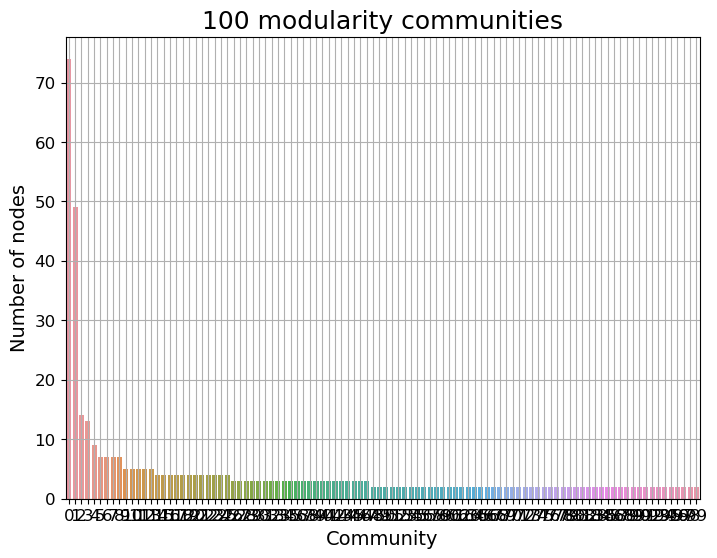

In [55]:
#plot modularity community sizes
fig = plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
ax = sns.countplot(data=df_mod, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_mod} modularity communities", fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()

### Draw Similarity Network (If Not Too Big)

In [56]:
Colors = [np.random.uniform(0,1,3) for _ in range(ncomm_mod)]


In [57]:
node_color_mod = [Colors[df_mod.community[df_mod.screen_name==node].values[0]] for node in Gsim.nodes()]



In [58]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10

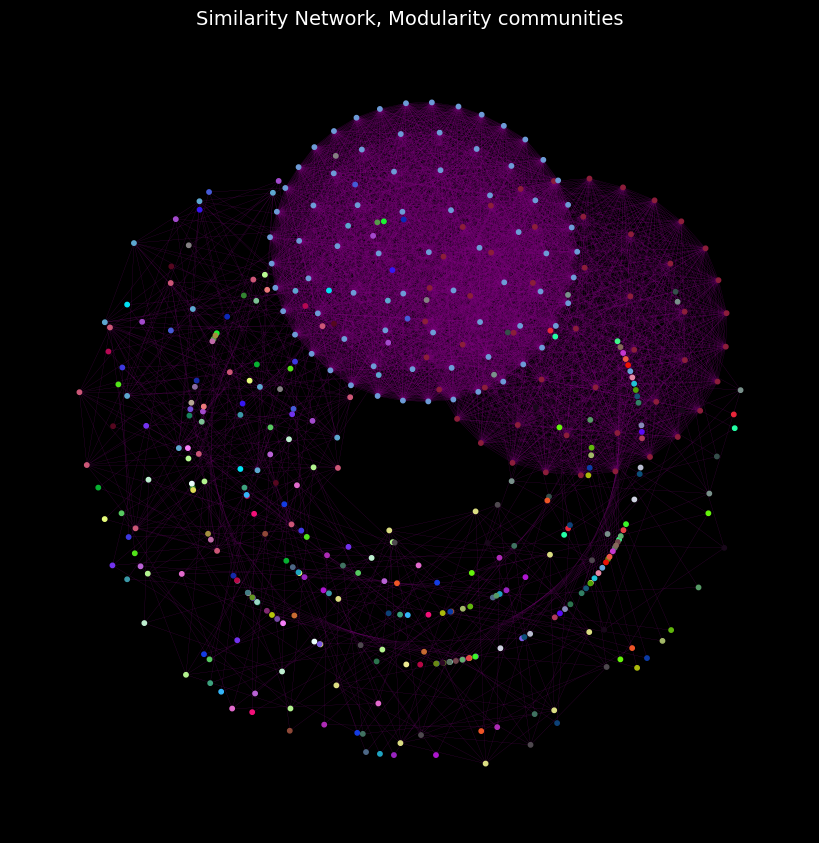

Wall time: 3.12 s


In [59]:
%%time
nv_max = 1000
nv = Gsim.number_of_nodes()

if nv<nv_max:
    pos = nx.kamada_kawai_layout(Gsim.to_undirected())  #position of each node in the network
    fig = plt.figure(figsize=(8,8))
    nx.draw(Gsim, pos, 
            node_color = node_color_mod, 
            width= edge_width, 
            edge_color=edge_color,
            node_size=node_size,
           with_labels=False,
            font_color = 'white')
    fig.set_facecolor(background_color)
    plt.title("Similarity Network, Modularity communities",color = 'white',fontsize = 14)
    plt.show()
    
else: print(f"Network has {nv} nodes, which is more than {nv_max}")